<a href="https://colab.research.google.com/github/benihime91/pytorch_retinanet/blob/master/nbs/_init_test_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%javascript
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}setInterval(ClickConnect,60000)

<IPython.core.display.Javascript object>

In [2]:
! nvidia-smi

Wed Aug 26 10:22:08 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
%%bash
git clone https://github.com/benihime91/pytorch_retinanet.git
echo ">> Repo Cloned"
tar zxf /content/drive/My\ Drive/Data/oxford-iiit-pet.tgz -C /content/ 
echo ">> Data Unziped"
pip install -U pytorch-lightning --quiet 
pip install -U git+https://github.com/albumentations-team/albumentations --quiet
pip install -U bounding_box --quiet
echo ">> Libraries successfully installed ! Proceed !!!"

>> Repo Cloned
>> Data Unziped
>> Libraries successfully installed ! Proceed !!!


Cloning into 'pytorch_retinanet'...
ERROR: tensorflow 2.3.0 has requirement tensorboard<3,>=2.3.0, but you'll have tensorboard 2.2.0 which is incompatible.


In [4]:
import os
os.chdir('/content/pytorch_retinanet')

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
import cv2
import pandas as pd
from sklearn import preprocessing, model_selection
import albumentations as A
from albumentations.pytorch import ToTensorV2
import warnings
import re
import xml.etree.ElementTree as ET
from pathlib import Path
from src.models import Retinanet
from src.eval_utils.coco_eval import CocoEvaluator
from src.eval_utils.coco_utils import get_coco_api_from_dataset
pl.seed_everything(356)
warnings.filterwarnings("ignore")

# Paths
img_desc = Path("/content/oxford-iiit-pet/images")
annot_dir = Path("/content/oxford-iiit-pet/annotations/xmls")
annots = list(annot_dir.iterdir())
annots = [str(a) for a in annots]

def xml_to_csv(pths):
    'Utility function to convert the xml files to csv files'
    xml_list = []
    for xml_file in pths:
        # Read in the xml file
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for m in root.findall("object"):
            try:
                value = (
                    # Extract the path to the image
                    str(img_desc / root.find("filename").text),
                    # Extract the bounding boxes
                    # 1. xmin
                    float(m[4][0].text),
                    # 2. ymin
                    float(m[4][1].text),
                    # 3. xmax
                    float(m[4][2].text),
                    # 4. ymax
                    float(m[4][3].text),
                )
                xml_list.append(value)
            except:
                pass
    col_n = ["filename", "xmin", "ymin", "xmax", "ymax"]
    df = pd.DataFrame(xml_list, columns=col_n)
    return df
##############################################################################################################
########################################  Data Preprocessing  ################################################
##############################################################################################################
df = xml_to_csv(annots)
pat = r"/([^/]+)_\d+.jpg$"
pat = re.compile(pat)

df["class"] = [pat.search(fname).group(1).lower() for fname in df.filename]

le = preprocessing.LabelEncoder()
df["target"] = le.fit_transform(df["class"].values)

df = df.sample(frac=1).reset_index(drop=True)
df , _ = model_selection.train_test_split(df, stratify=df["target"], test_size=0.25, shuffle=True)

df_train, df_test = model_selection.train_test_split(df, stratify=df["target"], test_size=0.25, shuffle=True)
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)
##############################################################################################################
###################################### Image Transformations #################################################
##############################################################################################################
transformations = [
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.4),
]

# Train Transformations
train_transformations = transformations + [
    A.ToFloat(max_value=255.0, always_apply=True),
    ToTensorV2(always_apply=True),
]

# Valid Transformations
valid_transformations = [
    A.ToFloat(max_value=255.0, always_apply=True),
    ToTensorV2(always_apply=True),
]

# Transformations:
transforms = {
    "train": A.Compose(
        train_transformations,
        p=1.0,
        bbox_params=A.BboxParams(format="pascal_voc", label_fields=["class_labels"]),
    ),
    "valid": A.Compose(
        valid_transformations,
        p=1.0,
        bbox_params=A.BboxParams(format="pascal_voc", label_fields=["class_labels"]),
    ),
}
##############################################################################################################
#################################### Utily Classes and Functions #############################################
##############################################################################################################
def collate_fn(batch):     
    return tuple(zip(*batch))

# Torch.utils.data.Dataset Class
class Dataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, train):
        self.df = dataframe
        self.image_ids = self.df["filename"]
        if train:
            self.tfms = transforms["train"]
        else:
            self.tfms = transforms["valid"]

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        # Grab the Image
        image_id = self.image_ids[idx]
        im = cv2.cvtColor(cv2.imread(image_id), cv2.COLOR_BGR2RGB)
        # extract the bounding boxes
        records = self.df[self.df["filename"] == image_id]
        boxes = records[["xmin", "ymin", "xmax", "ymax"]].values
        # claculate area
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)
        # Grab the Class Labels
        class_labels = records["target"].values.tolist()
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        # apply transformations
        transformed = self.tfms(image=im, bboxes=boxes, class_labels=class_labels)
        image = transformed["image"]
        boxes = torch.tensor(transformed["bboxes"], dtype=torch.float32)
        class_labels = torch.tensor(transformed["class_labels"])
        # target dictionary
        target = {}
        image_idx = torch.tensor([idx])
        target["image_id"] = image_idx
        target["boxes"] = boxes
        target["labels"] = class_labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        return image, target, image_idx

In [6]:
# LightningModule
class LitModel(pl.LightningModule):
    def __init__(
        self,
        model: nn.Module,
        train_dl: torch.utils.data.DataLoader,
        val_dl: torch.utils.data.DataLoader,
        max_lr: float,
        num_epochs: int,
    ):

        super(LitModel, self).__init__()
        self.model = model
        self.train_dl = train_dl
        self.val_dl = val_dl
        self.learning_rate = max_lr
        self.num_epochs = num_epochs

    def configure_optimizers(self, *args, **kwargs):
        # Grab trinable model Parameters
        params = [p for p in self.model.parameters() if p.requires_grad]
        # Instantiate Optimizer
        self.optimizer = optim.AdamW(
            params, 
            lr=(self.learning_rate or self.lr), 
            weight_decay=1e-02,
        )

        # Instantiate Scheduler
        self.scheduler = {
            "scheduler": (
                torch.optim.lr_scheduler.OneCycleLR(
                    optimizer=self.optimizer,
                    max_lr=(self.learning_rate or self.lr),
                    steps_per_epoch=len(self.train_dl),
                    epochs=self.num_epochs,
                )
            ),
            "interval": "step",
            "frequency": 1,
        }

        return [self.optimizer], [self.scheduler]

    def forward(self, x, *args, **kwargs):
        return self.model(x)

    def train_dataloader(self, *args, **kwargs):
        return self.train_dl

    def val_dataloader(self, *args, **kwargs):
        valid_loader = self.val_dl
        # Prepare COCO Evaluator
        coco = get_coco_api_from_dataset(valid_loader.dataset)
        iou_types = ["bbox"]
        self.coco_evaluator = CocoEvaluator(coco, iou_types)
        return valid_loader

    def training_step(self, batch, batch_idx, *args, **kwargs):
        images, targets, _ = batch
        targets = [{k: v for k, v in t.items()} for t in targets]
        # Separate Losses
        loss_dict = self.model(images, targets)
        # Total Loss
        losses = sum(loss for loss in loss_dict.values())
        # add learning rate
        loss_dict["lr"] = self.optimizer.param_groups[0]["lr"]
        return {"loss": losses, "log": loss_dict, "progress_bar": loss_dict}

    def validation_step(self, batch, batch_idx, *args, **kwargs):
        images, targets, _ = batch
        targets = [{k: v for k, v in t.items()} for t in targets]
        outputs = self.model(images, targets)
        res = {
            target["image_id"].item(): output
            for target, output in zip(targets, outputs)
        }
        self.coco_evaluator.update(res)
        return {}

    def validation_epoch_end(self, outputs):
        self.coco_evaluator.accumulate()
        self.coco_evaluator.summarize()
        # coco main metric
        metric = self.coco_evaluator.coco_eval["bbox"].stats[0]
        metric = torch.as_tensor(metric)
        tensorboard_logs = {"bbox_IOU": metric}
        return {
            "val_loss": metric,
            "log": tensorboard_logs,
            "progress_bar": tensorboard_logs,
        }

In [7]:
def get_trainer():
    TRAIN_BATCH_SIZE = 15
    VALID_BATCH_SIZE = 32
    EPOCHS = 20
    MAX_LR = 1e-03/5
    NUM_CLASSES = len(df["target"].unique())

    model = Retinanet(
        num_classes=NUM_CLASSES,
        backbone_kind="resnet18",
        pretrained=True,
        freeze_bn=True,
    )

    # DataLoaders
    train_ds = Dataset(df_train, train=True)
    train_dl = DataLoader(
        train_ds,
        batch_size=TRAIN_BATCH_SIZE,
        shuffle=True,
        collate_fn=collate_fn,
        pin_memory=True,
    )

    val_ds = Dataset(df_test, train=False)
    val_dl = DataLoader(
        val_ds,
        batch_size=VALID_BATCH_SIZE,
        shuffle=False,
        collate_fn=collate_fn,
        pin_memory=True,
    )

    # Callbacks
    tb_logger = pl.loggers.TensorBoardLogger(save_dir="/content/logs")

    save_dir = "/content/saved_models"
    checkpoint_callback = pl.callbacks.ModelCheckpoint(
        save_dir, mode="max", monitor="bbox_IOU", save_top_k=-1
    )
    early_stopping_callback = pl.callbacks.EarlyStopping(
        mode="max", monitor="bbox_IOU", patience=10
    )

    # Instantiate Lightning Module
    lightning_model = LitModel(
        model, train_dl, val_dl, max_lr=MAX_LR, num_epochs=EPOCHS
    )
    # Instantiate Trainer
    trainer = pl.Trainer(
        logger=[tb_logger],
        num_sanity_val_steps=0,
        early_stop_callback=early_stopping_callback,
        checkpoint_callback=checkpoint_callback,
        max_epochs=EPOCHS,
        precision=16,
        gpus=1,
    )

    return trainer, lightning_model

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.

  | Name  | Type      | Params
------------------------------------
0 | model | Retinanet | 20 M  


creating index...
index created!


Saving latest checkpoint..


LR finder stopped early due to diverging loss.


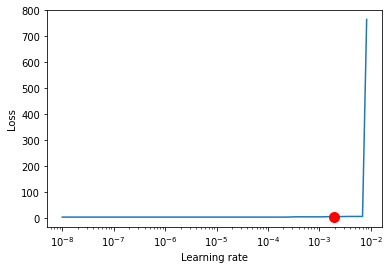

In [8]:
trainer, model = get_trainer()
lr_finder = trainer.lr_find(model)
fig = lr_finder.plot(suggest=True)
fig.show()

In [ ]:
new_lr = 5e-03
model.hparams.lr = new_lr
trainer.fit(model)


  | Name  | Type      | Params
------------------------------------
0 | model | Retinanet | 20 M  


creating index...
index created!


Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.93s).
Accumulating evaluation results...
DONE (t=0.24s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.079
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.170
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.096
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.149
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.090
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.244
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.416
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.453
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=m

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.50s).
Accumulating evaluation results...
DONE (t=0.17s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.063
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.152
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.047
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.218
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.072
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.247
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.491
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.497
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=m

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.36s).
Accumulating evaluation results...
DONE (t=0.13s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.060
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.164
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.019
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.156
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.072
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.219
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.375
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.406
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=m

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.39s).
Accumulating evaluation results...
DONE (t=0.16s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.151
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.327
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.134
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.320
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.164
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.291
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.487
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.500
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=m

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.35s).
Accumulating evaluation results...
DONE (t=0.13s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.174
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.507
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.121
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.246
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.213
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.284
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.428
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.434
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=m

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.33s).
Accumulating evaluation results...
DONE (t=0.13s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.223
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.525
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.217
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.589
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.169
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.353
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.428
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.438
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=m